In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np
import torchaudio
import torch

tensor(-73.4757) tensor(76.3676)
-0.42897514


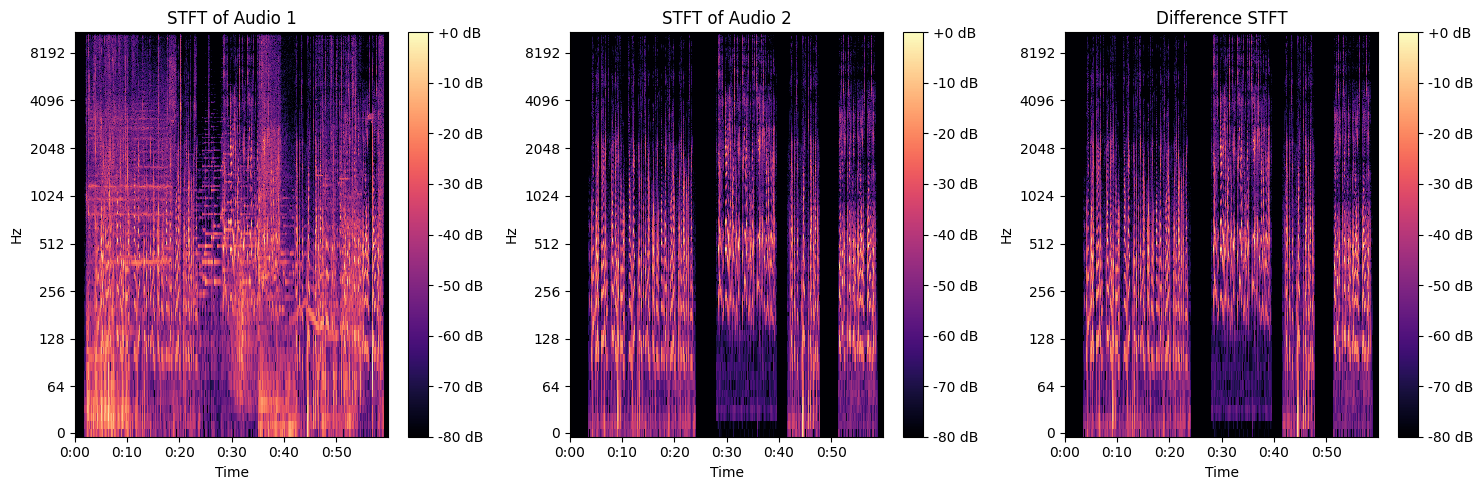

In [3]:
def process_audio(file1, file2, file3, file4):
    """Loads two audio files, calculates their STFTs, subtracts the difference, and displays the results."""

    try:
        # Load audio files
        y1, sr1 = librosa.load(file1)
        y2, sr2 = librosa.load(file2)
        y3, sr3 = librosa.load(file3)
        y4, sr4 = librosa.load(file4)

        y5 = y1 - (y3 + y4)

        # Check if sample rates are the same
        if sr1 != sr2:
            print(
                "Warning: Sample rates of the two audio files are different. Resampling to the first file's sample rate.")
            y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
            sr2 = sr1

        # Calculate STFTs
        stft1 = librosa.stft(y1)
        stft2 = np.abs(librosa.stft(y2))
        stft3 = np.abs(librosa.stft(y3))
        stft4 = np.abs(librosa.stft(y4))
        stft5 = librosa.stft(y5)
        c = torch.from_numpy(y5)
        c = torch.stft(c,n_fft=2048,window=torch.hann_window(2048),return_complex=True)
        d = torch.view_as_real(c)
        print(d.min(), d.max())
        print(y5.min())

        # Subtract the difference (handle potential shape mismatch)
        min_shape = min(stft1.shape[1], stft2.shape[1])
        diff_stft = stft1[:, :min_shape] - stft5[:, :min_shape]
        
        stft1 = np.abs(stft1)
        stft5 = np.abs(stft5)
        diff_stft = np.abs(diff_stft)

        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        librosa.display.specshow(librosa.amplitude_to_db(stft1, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 1')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 2)
        librosa.display.specshow(librosa.amplitude_to_db(stft2, ref=np.max), sr=sr2, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 2')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 3)
        librosa.display.specshow(librosa.amplitude_to_db(stft5, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('Difference STFT')
        plt.colorbar(format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("Error: One or both audio files not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage: Replace 'audio1.wav' and 'audio2.wav' with your file paths.
top_dir = "46841"
process_audio(f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/mix.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/speech.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/sfx.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/music.wav")